In [1]:
import numpy as np
import matplotlib

In [2]:
def calculate_ColumnEi_layer_params(total: int, ratio):
    """
    For a ColumnEi model layer_params is a total number of units, and a ratio e.g 20, for 20:1.
    This is a util function to calculate n_e, n_i.
    Args:
        ratio : int
        total : int, total number of units (typically n_input to a layer)
    """
    fraction = total / (ratio+1)
    n_i = int(np.ceil(fraction))
    n_e = int(np.floor(fraction * ratio))
    return n_e, n_i

In [3]:
spectral_radius = 1.5
entropy_list = []
np.random.seed(0)

for n_hidden in np.linspace(100, 1000, 10, dtype=int):
    for ratio in (1/np.linspace(0.01,0.5,10)) -1 :
        ne, ni = calculate_ColumnEi_layer_params(n_hidden, ratio)

        denom = ((2 * np.pi - 1) / (2 * np.pi)) * (ne + (ne ** 2 / ni))

        sigma_we = np.sqrt(1 / denom)
        sigma_wi = (ne / ni) * sigma_we

        We_np = np.random.exponential(scale=sigma_we, size=(n_hidden, ne))
        Wi_np = -np.random.exponential(scale=sigma_wi, size=(n_hidden, ni))

        W = np.concatenate([We_np, Wi_np], axis=1)

        if spectral_radius is not None: 
            w, v = np.linalg.eig(W)
            rho = np.max( np.sqrt(np.power(np.real(w), 2) + np.power(np.imag(w), 2)) )
            W *= (spectral_radius / rho)

        _, sigma, _ = np.linalg.svd(W)
        
        norm_norm_entropy = -(np.log(sigma/sigma.sum()) * sigma/sigma.sum()).sum() / np.log(len(sigma))
        entropy_list.append(norm_norm_entropy)
entropy_list = np.reshape(entropy_list, (10, 10))

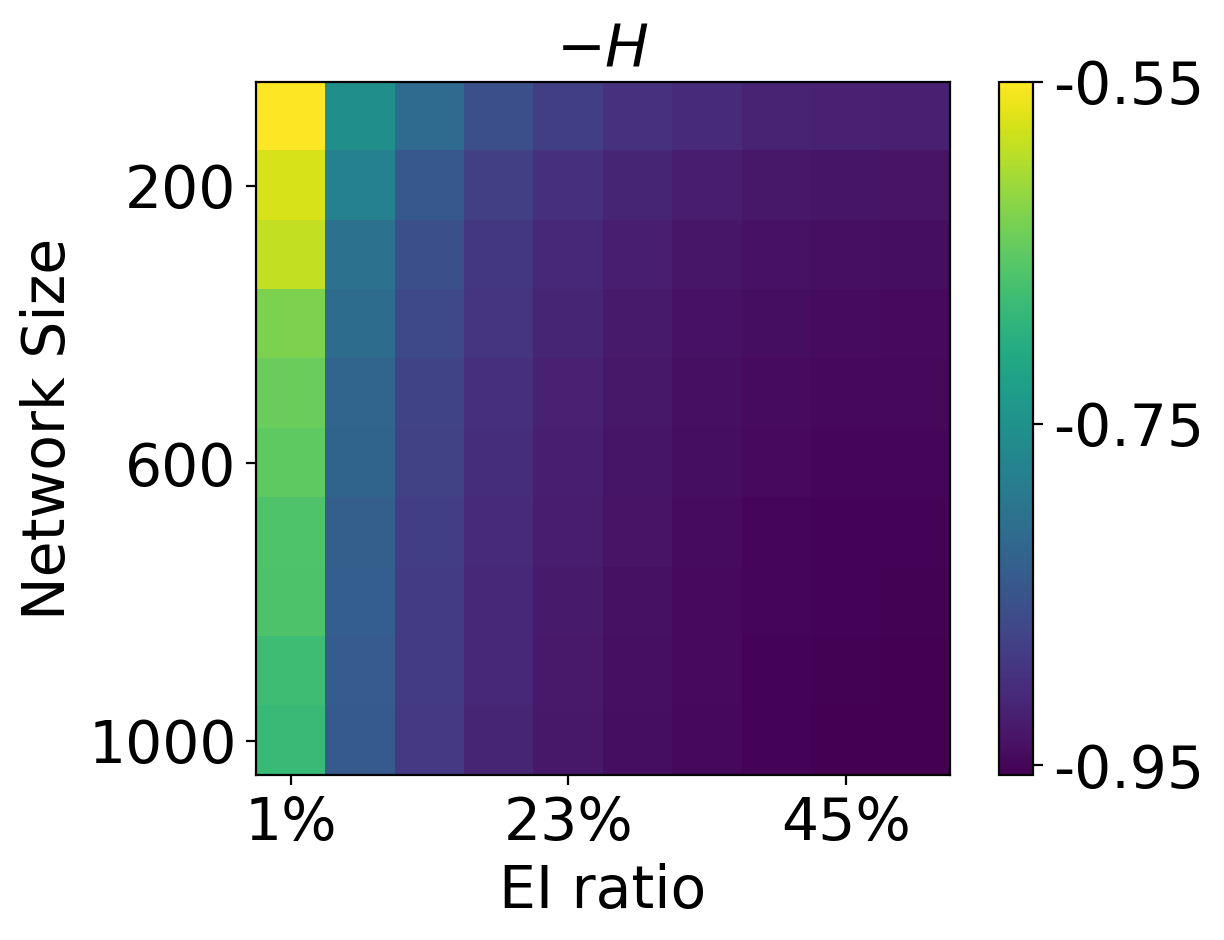

In [15]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
matplotlib.rcParams['figure.dpi'] = 200
# matplotlib.rcParams["figure.figsize"] = (5,4)

plt.imshow(-entropy_list, vmax=-0.55)
plt.title(r'$-H$', fontsize=21)
plt.yticks(ticks=range(1,11,4), labels=range(200,1200,400),fontsize=21)
plt.xticks(ticks=[0,4,8], labels=["1%","23%","45%"],fontsize=21)
plt.ylabel("Network Size",fontsize=21)
plt.xlabel("EI ratio",fontsize=21)
cbar = plt.colorbar()
cbar.set_ticks([-0.55, -0.75, -0.95])
cbar.set_ticklabels([-0.55, -0.75, -0.95], size=21)
plt.tight_layout()
plt.savefig('neg_Entropy_heatmap.svg', format='svg', dpi=200)
plt.savefig('neg_Entropy_heatmap.png', format='png', dpi=200)

plt.show()

In [16]:
# entropy_list = []
seeds=5
song_rnn = {k: np.zeros((seeds,562)) for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}
song_acc_mean_list = []
#song_loss_mean_list = []
for n_hidden in np.linspace(100, 1000, 10, dtype=int):
    for ratio in np.round((1/np.linspace(0.01,0.5,10))-1,3):
        song_acc_list = []
        #song_loss_list = []
        song_acc_list_2 = []
        for i in range(seeds):
            s = np.load(f'/network/projects/linclab_users/danns/playground/seq_mnist_colei_ei_size_grid/batch_size-32/seed-{i}/colei_learning_curves_seed{i}_hidden{n_hidden}_ei{ratio}_lr0.01_GC10_rad1.5.npz')

            song_rnn["train_err"][i, :] = s["train_err"]
            song_rnn["test_err"][i, :] = s["test_err"]
            song_rnn["train_loss"][i, :] = s["train_loss"]
            song_rnn["test_loss"][i, :] = s["test_loss"]
            song_rnn["update"][i, :] = s["update"]

            song_acc_list.append(s["test_err"][-1])
            # song_loss_list.append(s["test_loss"][-1])
            
            s = np.load(f'/network/projects/linclab_users/danns/playground/seq_mnist_colei_ei_size_grid/batch_size-32/seed-{i}/colei_learning_curves_seed{i}_hidden{n_hidden}_ei{ratio}_lr0.01_GC5_rad1.5.npz')

            song_rnn["train_err"][i, :] = s["train_err"]
            song_rnn["test_err"][i, :] = s["test_err"]
            song_rnn["train_loss"][i, :] = s["train_loss"]
            song_rnn["test_loss"][i, :] = s["test_loss"]
            song_rnn["update"][i, :] = s["update"]
            
            song_acc_list_2.append(s["test_err"][-1])
        
        song_acc_mean_list.append(min(np.mean(song_acc_list), np.mean(song_acc_list_2)))
        #song_loss_mean_list.append(np.mean(song_loss_list))
        
song_acc_mean_list = np.reshape(song_acc_mean_list, (10,10))
#song_loss_mean_list = np.reshape(song_loss_mean_list, (10,10))


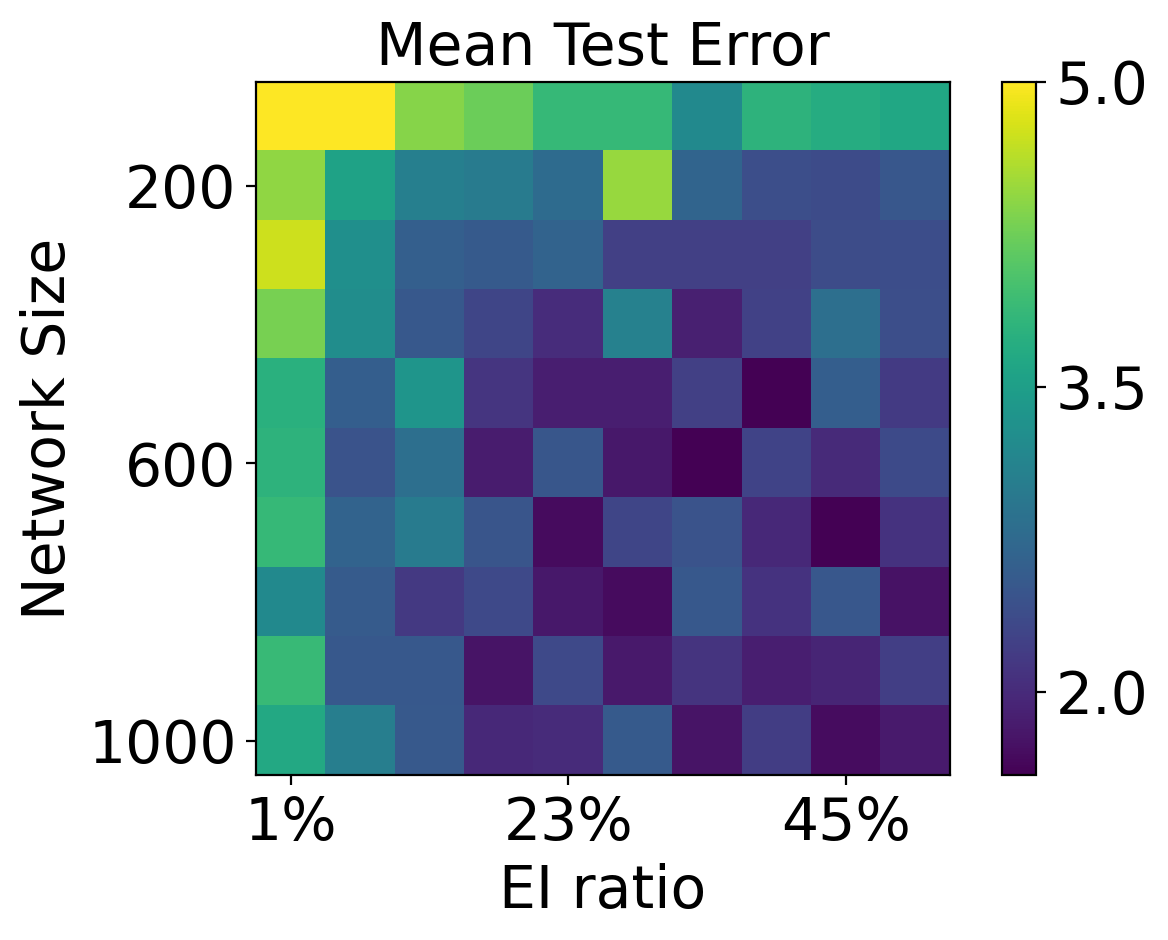

In [21]:
plt.imshow(song_acc_mean_list,vmax=5)
cbar = plt.colorbar()
plt.title('Mean Test Error',fontsize=21)
plt.yticks(ticks=range(1,11,4), labels=range(200,1200,400),fontsize=21)
plt.xticks(ticks=[0,4,8], labels=["1%","23%","45%"],fontsize=21)
plt.ylabel("Network Size",fontsize=21)
plt.xlabel("EI ratio",fontsize=21)

cbar.set_ticks([2.0, 3.5, 5.0])
cbar.set_ticklabels([2.0, 3.5, 5.0], size=21)
plt.tight_layout()
plt.savefig('nolog_Error_heatmap.svg', format='svg', dpi=200)
plt.savefig('nolog_Error_heatmap.png', format='png', dpi=200)

plt.show()

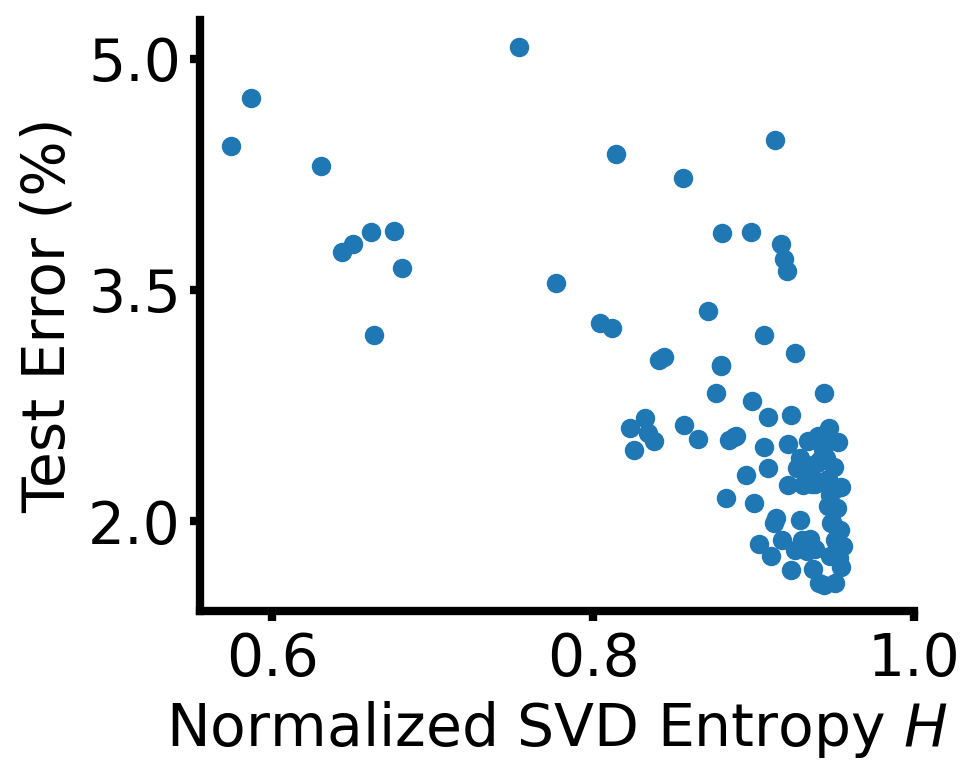

In [65]:
ax = plt.subplot(111)
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams["figure.figsize"] = (5,4)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_linewidth(3)
ax.spines.bottom.set_linewidth(3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)

plt.scatter(entropy_list.reshape(-1)[1:], song_acc_mean_list.reshape(-1)[1:])
plt.ylabel('Test Error (%)',fontsize=21)
plt.xlabel(r'Normalized SVD Entropy $H$', fontsize=21)
plt.yticks([2.0, 3.5, 5.0],fontsize=21)
plt.xticks([0.6, 0.8, 1.0],fontsize=21)
plt.tight_layout()

plt.savefig('Error_H_regression_linear.svg', format='svg', dpi=200)
plt.savefig('Error_H_regression_linear.png', format='png', dpi=200)

plt.show()

In [50]:
seeds=5
song_rnn_high_entropy = {k: np.zeros((seeds,562)) for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}
song_rnn_low_entropy = {k: np.zeros((seeds,562)) for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}

for i in range(seeds):
    s = np.load(f'/network/projects/linclab_users/danns/playground/seq_mnist_colei_ei_size_grid/batch_size-32/seed-{i}/colei_learning_curves_seed{i}_hidden200_ei1.0_lr0.01_GC10_rad1.5.npz')

    song_rnn_high_entropy["train_err"][i, :] = s["train_err"]
    song_rnn_high_entropy["test_err"][i, :] = s["test_err"]
    song_rnn_high_entropy["train_loss"][i, :] = s["train_loss"]
    song_rnn_high_entropy["test_loss"][i, :] = s["test_loss"]
    song_rnn_high_entropy["update"][i, :] = s["update"]

    s = np.load(f'/network/projects/linclab_users/danns/playground/seq_mnist_colei_ei_size_grid/batch_size-32/seed-{i}/colei_learning_curves_seed{i}_hidden1000_ei99.0_lr0.01_GC10_rad1.5.npz')

    song_rnn_low_entropy["train_err"][i, :] = s["train_err"]
    song_rnn_low_entropy["test_err"][i, :] = s["test_err"]
    song_rnn_low_entropy["train_loss"][i, :] = s["train_loss"]
    song_rnn_low_entropy["test_loss"][i, :] = s["test_loss"]
    song_rnn_low_entropy["update"][i, :] = s["update"]
    
print(song_rnn_high_entropy["test_err"].mean(axis=0)[-1])
print(song_rnn_low_entropy["test_err"].mean(axis=0)[-1])            


2.52
3.642000000000001


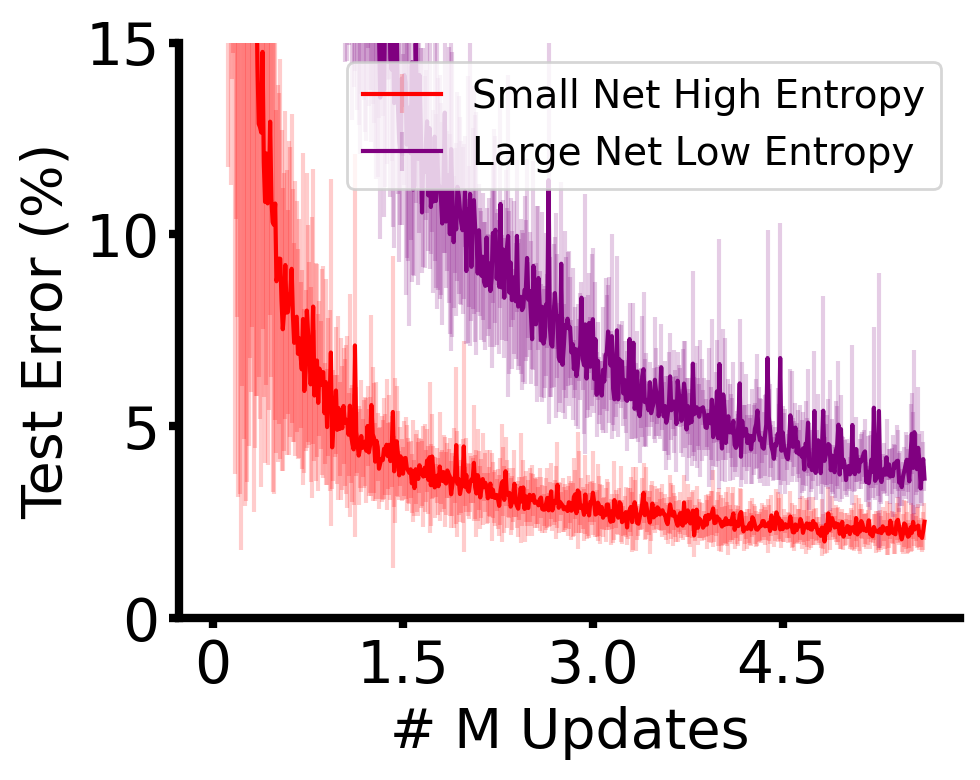

In [61]:
ax = plt.subplot(111)
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams["figure.figsize"] = (5,4)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_linewidth(3)
ax.spines.bottom.set_linewidth(3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)

# fig, axes = plt.subplots(dpi=100)
# plt.figure(figsize=(8,5))
plt.xlabel('# M Updates', fontsize=20)
plt.ylabel('Test Error (%)', fontsize=20)
transparency = 0.2

_, _, bars = plt.errorbar(x=song_rnn_high_entropy["update"].mean(axis=0), y=song_rnn_high_entropy["test_err"].mean(axis=0), yerr=song_rnn_high_entropy["test_err"].std(axis=0), color='red')
[bar.set_alpha(transparency) for bar in bars]

_, _, bars = plt.errorbar(x=song_rnn_low_entropy["update"].mean(axis=0), y=song_rnn_low_entropy["test_err"].mean(axis=0), yerr=song_rnn_low_entropy["test_err"].std(axis=0), color='purple')
[bar.set_alpha(transparency) for bar in bars]
# _, _, bars = plt.errorbar(x=song_rnn_no_ablate["update"].mean(axis=0), y=song_rnn_no_ablate["test_err"].mean(axis=0), yerr=song_rnn_no_ablate["test_err"].std(axis=0), color='b')
# [bar.set_alpha(transparency) for bar in bars]

plt.ylim([0, 15])
#plt.legend(["DANN", "RNN Vecs with ColEI Spectrum", "ColEI Vecs with RNN Spectrum", "ColEI Vecs with ColEI Spectrum", "Orginal RNN"], fontsize=9, frameon=True)
#plt.legend(["RNN Vecs with ColEI Spectrum", "ColEI Vecs with RNN Spectrum", "Original ColEI", "Orginal RNN"], fontsize=9, frameon=True)
plt.legend(["Small Net High Entropy",  "Large Net Low Entropy"], fontsize=14, frameon=True)
plt.yticks(ticks=[0, 5, 10,15], size=21)
plt.xticks(labels=["0", "1.5", "3.0", "4.5"], ticks=[0, 15000, 30000, 45000], size=21)
plt.tight_layout()

plt.savefig('Net_Size_and_Entropy.png', format='png', dpi=200)
plt.savefig('Net_Size_and_Entropy.svg', format='svg', dpi=200)

plt.show()